# KAN Autoencoders Sectoriels

Ce notebook entraine des autoencoders KAN (Kolmogorov-Arnold Networks) pour reconstituer les log returns par secteur.

## Objectifs
- Entrainer un autoencoder KAN pour chaque secteur
- Comparer les performances de reconstruction
- Visualiser les représentations latentes
- Analyser les patterns sectoriels


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
import warnings
from datetime import datetime
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from tqdm import tqdm

# Imports des modèles KAN
import sys
sys.path.append('src')
from models.ae_kan import KANAutoencoder
from models.ae_mlp import MLPAutoencoder

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"🚀 Notebook démarré le {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📱 Device disponible: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


🚀 Notebook démarré le 2025-08-24 19:41:45
📱 Device disponible: CUDA


## 1. Chargement et Préparation des Données


In [2]:
# Chemins des données
DATA_PATH = Path('data/processed/sectors')
RESULTS_PATH = Path('results')
FIGURES_PATH = Path('figures')

# Créer les dossiers de résultats s'ils n'existent pas
RESULTS_PATH.mkdir(exist_ok=True)
FIGURES_PATH.mkdir(exist_ok=True)

# Lister tous les secteurs disponibles
sectors = [d.name for d in DATA_PATH.iterdir() if d.is_dir()]
sectors = sorted([s for s in sectors if s != 'unknown'])  # Exclure le secteur 'unknown'

print(f"📊 Secteurs trouvés ({len(sectors)}):")
for i, sector in enumerate(sectors, 1):
    print(f"   {i:2d}. {sector.replace('_', ' ').title()}")


📊 Secteurs trouvés (11):
    1. Communication Services
    2. Consumer Discretionary
    3. Consumer Staples
    4. Energy
    5. Financials
    6. Health Care
    7. Industrials
    8. Information Technology
    9. Materials
   10. Real Estate
   11. Utilities


In [3]:
def load_sector_data(sector_name):
    """
    Charge les données de log returns pour un secteur donné.
    """
    file_path = DATA_PATH / sector_name / 'log_returns.csv'
    
    if not file_path.exists():
        print(f"❌ Fichier non trouvé: {file_path}")
        return None
    
    # Charger les données
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    
    # Supprimer les colonnes avec trop de valeurs manquantes (>50%)
    missing_pct = df.isnull().sum() / len(df)
    valid_columns = missing_pct[missing_pct <= 0.5].index
    df = df[valid_columns]
    
    # Supprimer les lignes avec des valeurs manquantes
    df_clean = df.dropna()
    
    print(f"📈 {sector_name.replace('_', ' ').title()}:")
    print(f"   • Période: {df_clean.index.min().strftime('%Y-%m-%d')} → {df_clean.index.max().strftime('%Y-%m-%d')}")
    print(f"   • Dimensions: {df_clean.shape[0]:,} jours × {df_clean.shape[1]} tickers")
    print(f"   • Tickers conservés: {len(valid_columns)}/{len(df.columns)} ({len(valid_columns)/len(df.columns)*100:.1f}%)")
    
    return df_clean

# Charger les données pour tous les secteurs
sector_data = {}
print("\n📂 Chargement des données sectorielles:")
print("=" * 80)

for sector in sectors:
    data = load_sector_data(sector)
    if data is not None and len(data) > 100:  # Au moins 100 observations
        sector_data[sector] = data
    print()

print(f"✅ Données chargées pour {len(sector_data)} secteurs")



📂 Chargement des données sectorielles:
📈 Communication Services:
   • Période: 2010-01-05 → 2024-12-31
   • Dimensions: 3,773 jours × 17 tickers
   • Tickers conservés: 17/17 (100.0%)

📈 Consumer Discretionary:
   • Période: 2010-01-05 → 2024-12-31
   • Dimensions: 3,773 jours × 43 tickers
   • Tickers conservés: 43/43 (100.0%)

📈 Consumer Staples:
   • Période: 2010-01-05 → 2024-12-31
   • Dimensions: 3,773 jours × 33 tickers
   • Tickers conservés: 33/33 (100.0%)

📈 Energy:
   • Période: 2010-01-05 → 2024-12-31
   • Dimensions: 3,773 jours × 16 tickers
   • Tickers conservés: 16/16 (100.0%)

📈 Financials:
   • Période: 2010-01-05 → 2024-12-31
   • Dimensions: 3,773 jours × 64 tickers
   • Tickers conservés: 64/64 (100.0%)

📈 Health Care:
   • Période: 2010-01-05 → 2024-12-31
   • Dimensions: 3,773 jours × 53 tickers
   • Tickers conservés: 53/53 (100.0%)

📈 Industrials:
   • Période: 2010-01-05 → 2024-12-31
   • Dimensions: 3,773 jours × 64 tickers
   • Tickers conservés: 64/64 (100

## 2. Configuration des Modèles


In [4]:
# Configuration des hyperparamètres pour les KAN autoencoders
KAN_CONFIG = {
    'k': 8,  # Dimension latente
    'hidden_dims': [64, 16],  # Couches cachées: input -> 64 -> 16 -> k
    'basis_type': 'spline',  # 'spline' ou 'poly'
    'M': 16,  # Nombre de fonctions splines
    'poly_degree': 5,  # Degré polynomial (si basis_type='poly')
    'xmin': -3.0,
    'xmax': 3.0,
    'dropout_p': 0.1,
    'use_silu': True,
    # Régularisations
    'lambda_alpha': 1e-4,
    'lambda_group': 1e-5,
    'lambda_tv': 1e-4,
    'lambda_poly_decay': 0.0,
    # Skip connections
    'use_skip': True,
    'skip_init': 'zeros',
    'skip_gain': 0.1,
    'lambda_skip_l2': 0.0
}

# Configuration d'entraînement
TRAINING_CONFIG = {
    'epochs': 150,
    'batch_size': 64,
    'learning_rate': 0.001,
    'weight_decay': 1e-5,
    'validation_split': 0.2,
    'patience': 15,
    'lambda_reg': 1.0,
    'verbose': True
}

print("⚙️ CONFIGURATION DES MODÈLES")
print("=" * 50)
print("🔧 KAN Autoencoder:")
for key, value in KAN_CONFIG.items():
    print(f"   • {key}: {value}")

print("\n🏋️ Entraînement:")
for key, value in TRAINING_CONFIG.items():
    print(f"   • {key}: {value}")


⚙️ CONFIGURATION DES MODÈLES
🔧 KAN Autoencoder:
   • k: 8
   • hidden_dims: [64, 16]
   • basis_type: spline
   • M: 16
   • poly_degree: 5
   • xmin: -3.0
   • xmax: 3.0
   • dropout_p: 0.1
   • use_silu: True
   • lambda_alpha: 0.0001
   • lambda_group: 1e-05
   • lambda_tv: 0.0001
   • lambda_poly_decay: 0.0
   • use_skip: True
   • skip_init: zeros
   • skip_gain: 0.1
   • lambda_skip_l2: 0.0

🏋️ Entraînement:
   • epochs: 150
   • batch_size: 64
   • learning_rate: 0.001
   • weight_decay: 1e-05
   • validation_split: 0.2
   • patience: 15
   • lambda_reg: 1.0
   • verbose: True


## 3. Fonction d'Entraînement et d'Évaluation


In [5]:
def prepare_data(data, test_size=0.2, random_state=42):
    """
    Prépare les données pour l'entraînement.
    """
    # Convertir en numpy et gérer les NaN
    X = data.values
    
    # Supprimer les lignes avec des NaN
    mask = ~np.isnan(X).any(axis=1)
    X = X[mask]
    
    # Normalisation standard
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Division train/test temporelle (pas aléatoire pour des séries temporelles)
    n_train = int(len(X_scaled) * (1 - test_size))
    X_train = X_scaled[:n_train]
    X_test = X_scaled[n_train:]
    
    # Conversion en tenseurs PyTorch
    X_train_tensor = torch.FloatTensor(X_train)
    X_test_tensor = torch.FloatTensor(X_test)
    
    return X_train_tensor, X_test_tensor, scaler

def evaluate_model(model, X_test, scaler=None):
    """
    Évalue un modèle autoencoder.
    """
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        X_test_device = X_test.to(device)
        X_reconstructed, latent = model(X_test_device)
        
        # Calcul des métriques sur CPU
        X_test_np = X_test.cpu().numpy()
        X_recon_np = X_reconstructed.cpu().numpy()
        latent_np = latent.cpu().numpy()
        
        # Métriques de reconstruction
        mse = mean_squared_error(X_test_np, X_recon_np)
        mae = mean_absolute_error(X_test_np, X_recon_np)
        
        # R² de reconstruction (par feature)
        ss_res = np.sum((X_test_np - X_recon_np) ** 2, axis=0)
        ss_tot = np.sum((X_test_np - np.mean(X_test_np, axis=0)) ** 2, axis=0)
        r2_scores = 1 - (ss_res / (ss_tot + 1e-8))
        r2_mean = np.mean(r2_scores)
        
        metrics = {
            'mse': mse,
            'mae': mae,
            'r2_mean': r2_mean,
            'r2_scores': r2_scores,
            'latent_variance': np.var(latent_np, axis=0),
            'latent_mean': np.mean(latent_np, axis=0)
        }
        
        return metrics, X_recon_np, latent_np

print("✅ Fonctions d'évaluation définies")


✅ Fonctions d'évaluation définies


In [6]:
def train_kan_autoencoder(sector_name, data, config=None):
    """
    Entraine un KAN autoencoder pour un secteur donné.
    """
    if config is None:
        config = {**KAN_CONFIG, **TRAINING_CONFIG}
    
    print(f"\n🚀 ENTRAÎNEMENT KAN AUTOENCODER - {sector_name.replace('_', ' ').title()}")
    print("=" * 80)
    
    # Préparer les données
    X_train, X_test, scaler = prepare_data(data, test_size=config['validation_split'])
    input_dim = X_train.shape[1]
    
    print(f"📊 Données: {X_train.shape[0]} train, {X_test.shape[0]} test, {input_dim} features")
    
    # Créer le modèle
    model = KANAutoencoder(
        input_dim=input_dim,
        k=config['k'],
        hidden_dims=config['hidden_dims'],
        basis_type=config['basis_type'],
        M=config['M'],
        poly_degree=config['poly_degree'],
        xmin=config['xmin'],
        xmax=config['xmax'],
        dropout_p=config['dropout_p'],
        use_silu=config['use_silu'],
        lambda_alpha=config['lambda_alpha'],
        lambda_group=config['lambda_group'],
        lambda_tv=config['lambda_tv'],
        lambda_poly_decay=config['lambda_poly_decay'],
        use_skip=config['use_skip'],
        skip_init=config['skip_init'],
        skip_gain=config['skip_gain'],
        lambda_skip_l2=config['lambda_skip_l2']
    )
    
    # Entraînement
    start_time = time.time()
    history = model.fit(
        X_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        validation_split=0.2,  # Validation sur l'ensemble d'entraînement
        patience=config['patience'],
        verbose=config['verbose'],
        lambda_reg=config['lambda_reg']
    )
    
    training_time = time.time() - start_time
    
    # Évaluation sur le test set
    test_metrics, X_recon, latent = evaluate_model(model, X_test, scaler)
    
    print(f"\n📊 RÉSULTATS FINAUX:")
    print(f"   • Temps d'entraînement: {training_time:.2f}s")
    print(f"   • MSE test: {test_metrics['mse']:.6f}")
    print(f"   • MAE test: {test_metrics['mae']:.6f}")
    print(f"   • R² moyen test: {test_metrics['r2_mean']:.4f}")
    
    results = {
        'sector': sector_name,
        'model': model,
        'history': history,
        'test_metrics': test_metrics,
        'training_time': training_time,
        'scaler': scaler,
        'config': config,
        'X_test': X_test,
        'X_reconstructed': X_recon,
        'latent_representation': latent
    }
    
    return results

print("✅ Fonction d'entraînement définie")


✅ Fonction d'entraînement définie


## 4. Entraînement des Modèles par Secteur


In [7]:
# Entraînement des modèles pour tous les secteurs
all_results = {}
training_summary = []

print("🎯 DÉBUT DE L'ENTRAÎNEMENT DES KAN AUTOENCODERS")
print("=" * 90)
print(f"📅 Démarrage: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 Configuration: {len(sector_data)} secteurs, {KAN_CONFIG['k']}D latent, {TRAINING_CONFIG['epochs']} epochs")

total_start_time = time.time()

for i, (sector, data) in enumerate(sector_data.items(), 1):
    print(f"\n{'='*90}")
    print(f"🏗️ SECTEUR {i}/{len(sector_data)}: {sector.replace('_', ' ').upper()}")
    print(f"{'='*90}")
    
    try:
        # Entraîner le modèle
        results = train_kan_autoencoder(sector, data, {**KAN_CONFIG, **TRAINING_CONFIG})
        all_results[sector] = results
        
        # Ajouter au résumé
        summary = {
            'Secteur': sector.replace('_', ' ').title(),
            'Features': data.shape[1],
            'Observations': data.shape[0],
            'Training_Time(s)': results['training_time'],
            'Final_Loss': results['history']['final_loss'],
            'MSE_Test': results['test_metrics']['mse'],
            'MAE_Test': results['test_metrics']['mae'],
            'R2_Mean': results['test_metrics']['r2_mean'],
            'Epochs_Trained': len(results['history']['train_loss'])
        }
        training_summary.append(summary)
        
        print(f"✅ Secteur {sector} terminé avec succès!")
        
    except Exception as e:
        print(f"❌ Erreur pour le secteur {sector}: {str(e)}")
        continue

total_time = time.time() - total_start_time

print(f"\n{'='*90}")
print(f"🎉 ENTRAÎNEMENT TERMINÉ!")
print(f"{'='*90}")
print(f"⏱️ Temps total: {total_time:.2f}s ({total_time/60:.2f} min)")
print(f"✅ Modèles entraînés: {len(all_results)}/{len(sector_data)}")
print(f"📅 Fin: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


🎯 DÉBUT DE L'ENTRAÎNEMENT DES KAN AUTOENCODERS
📅 Démarrage: 2025-08-24 19:42:27
🔧 Configuration: 11 secteurs, 8D latent, 150 epochs

🏗️ SECTEUR 1/11: COMMUNICATION SERVICES

🚀 ENTRAÎNEMENT KAN AUTOENCODER - Communication Services
📊 Données: 3018 train, 755 test, 17 features
🚀 ENTRAÎNEMENT KAN AUTOENCODER (ae_kan)
📊 Données: 2415 train, 603 val
🏗️  Architecture: 17 -> 64 -> 16 -> 8 -> 16 -> 64 -> 17
🔧 Device: cuda
⚙️  Paramètres: epochs=150, batch_size=64, lr=0.001
🎯 Régularisation: λ=1.0
🔢 Paramètres: 76,477 total, 76,477 entraînables
------------------------------------------------------------------------------------------
📈 Époque   1/150 | Train: 0.948190 | Val: 0.994049 ✅ | Reg: 0.020676 | LR: 1.00e-03 | ⏱️  11.7s (ETA: 1743.4s)
📈 Époque   2/150 | Train: 0.946723 | Val: 0.994320 ⚠️ | Reg: 0.002421 | LR: 1.00e-03 | ⏱️  17.2s (ETA: 1270.8s)
📈 Époque   3/150 | Train: 0.949691 | Val: 0.994517 ⚠️ | Reg: 0.001516 | LR: 1.00e-03 | ⏱️  22.6s (ETA: 1105.4s)
📈 Époque   4/150 | Train: 0.94764

## 5. Résumé des Résultats et Visualisations


In [8]:
# Tableau de résumé des performances
if training_summary:
    summary_df = pd.DataFrame(training_summary)
    summary_df = summary_df.sort_values('R2_Mean', ascending=False)
    
    print("📊 RÉSUMÉ DES PERFORMANCES PAR SECTEUR")
    print("=" * 120)
    print(summary_df.to_string(index=False, float_format='%.4f'))
    
    # Sauvegarder le résumé
    summary_df.to_csv(RESULTS_PATH / 'kan_autoencoders_summary.csv', index=False)
    print(f"\n💾 Résumé sauvegardé: {RESULTS_PATH / 'kan_autoencoders_summary.csv'}")
else:
    print("❌ Aucun résultat à afficher")


📊 RÉSUMÉ DES PERFORMANCES PAR SECTEUR
               Secteur  Features  Observations  Training_Time(s)  Final_Loss  MSE_Test  MAE_Test  R2_Mean  Epochs_Trained
                Energy        16          3773           77.0327      1.0370    0.8522    0.6723  -0.0005              16
            Financials        64          3773           76.8708      0.9965    1.0140    0.7068  -0.0006              16
             Utilities        29          3773           81.1187      0.9987    1.0053    0.7409  -0.0008              16
           Industrials        64          3773           79.7543      1.0024    0.9903    0.7080  -0.0008              16
             Materials        22          3773           77.3810      0.9733    1.1067    0.7374  -0.0010              16
Information Technology        53          3773           77.3507      0.9652    1.1392    0.7611  -0.0011              16
Consumer Discretionary        43          3773           89.4686      0.9882    1.0473    0.7203  -0.0011   

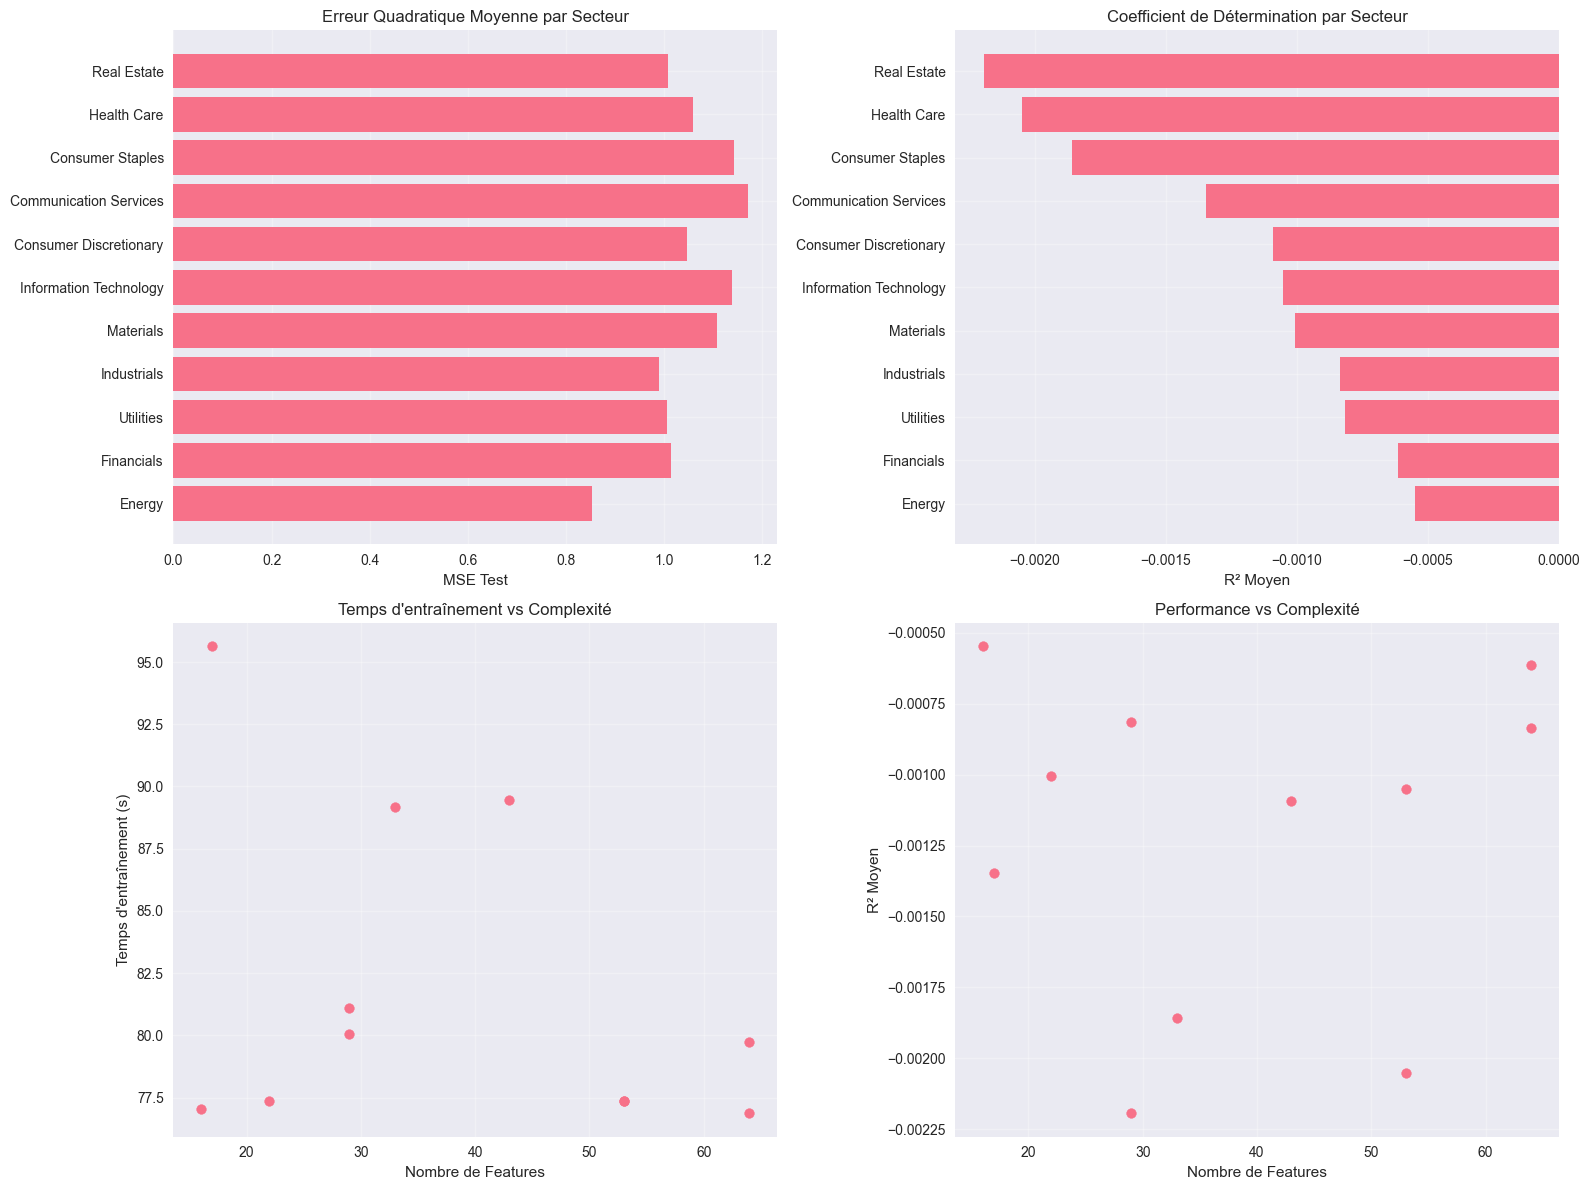

In [9]:
# Visualisation des performances
if training_summary:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # MSE par secteur
    axes[0,0].barh(summary_df['Secteur'], summary_df['MSE_Test'])
    axes[0,0].set_xlabel('MSE Test')
    axes[0,0].set_title('Erreur Quadratique Moyenne par Secteur')
    axes[0,0].grid(True, alpha=0.3)
    
    # R² par secteur
    axes[0,1].barh(summary_df['Secteur'], summary_df['R2_Mean'])
    axes[0,1].set_xlabel('R² Moyen')
    axes[0,1].set_title('Coefficient de Détermination par Secteur')
    axes[0,1].grid(True, alpha=0.3)
    
    # Temps d'entraînement vs nombre de features
    axes[1,0].scatter(summary_df['Features'], summary_df['Training_Time(s)'])
    axes[1,0].set_xlabel('Nombre de Features')
    axes[1,0].set_ylabel('Temps d\'entraînement (s)')
    axes[1,0].set_title('Temps d\'entraînement vs Complexité')
    axes[1,0].grid(True, alpha=0.3)
    
    # Performance vs complexité
    axes[1,1].scatter(summary_df['Features'], summary_df['R2_Mean'])
    axes[1,1].set_xlabel('Nombre de Features')
    axes[1,1].set_ylabel('R² Moyen')
    axes[1,1].set_title('Performance vs Complexité')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_PATH / 'kan_autoencoders_performances.png', 
                dpi=300, bbox_inches='tight')
    plt.show()


## 6. Analyse des Représentations Latentes


🔍 ANALYSE DES REPRÉSENTATIONS LATENTES


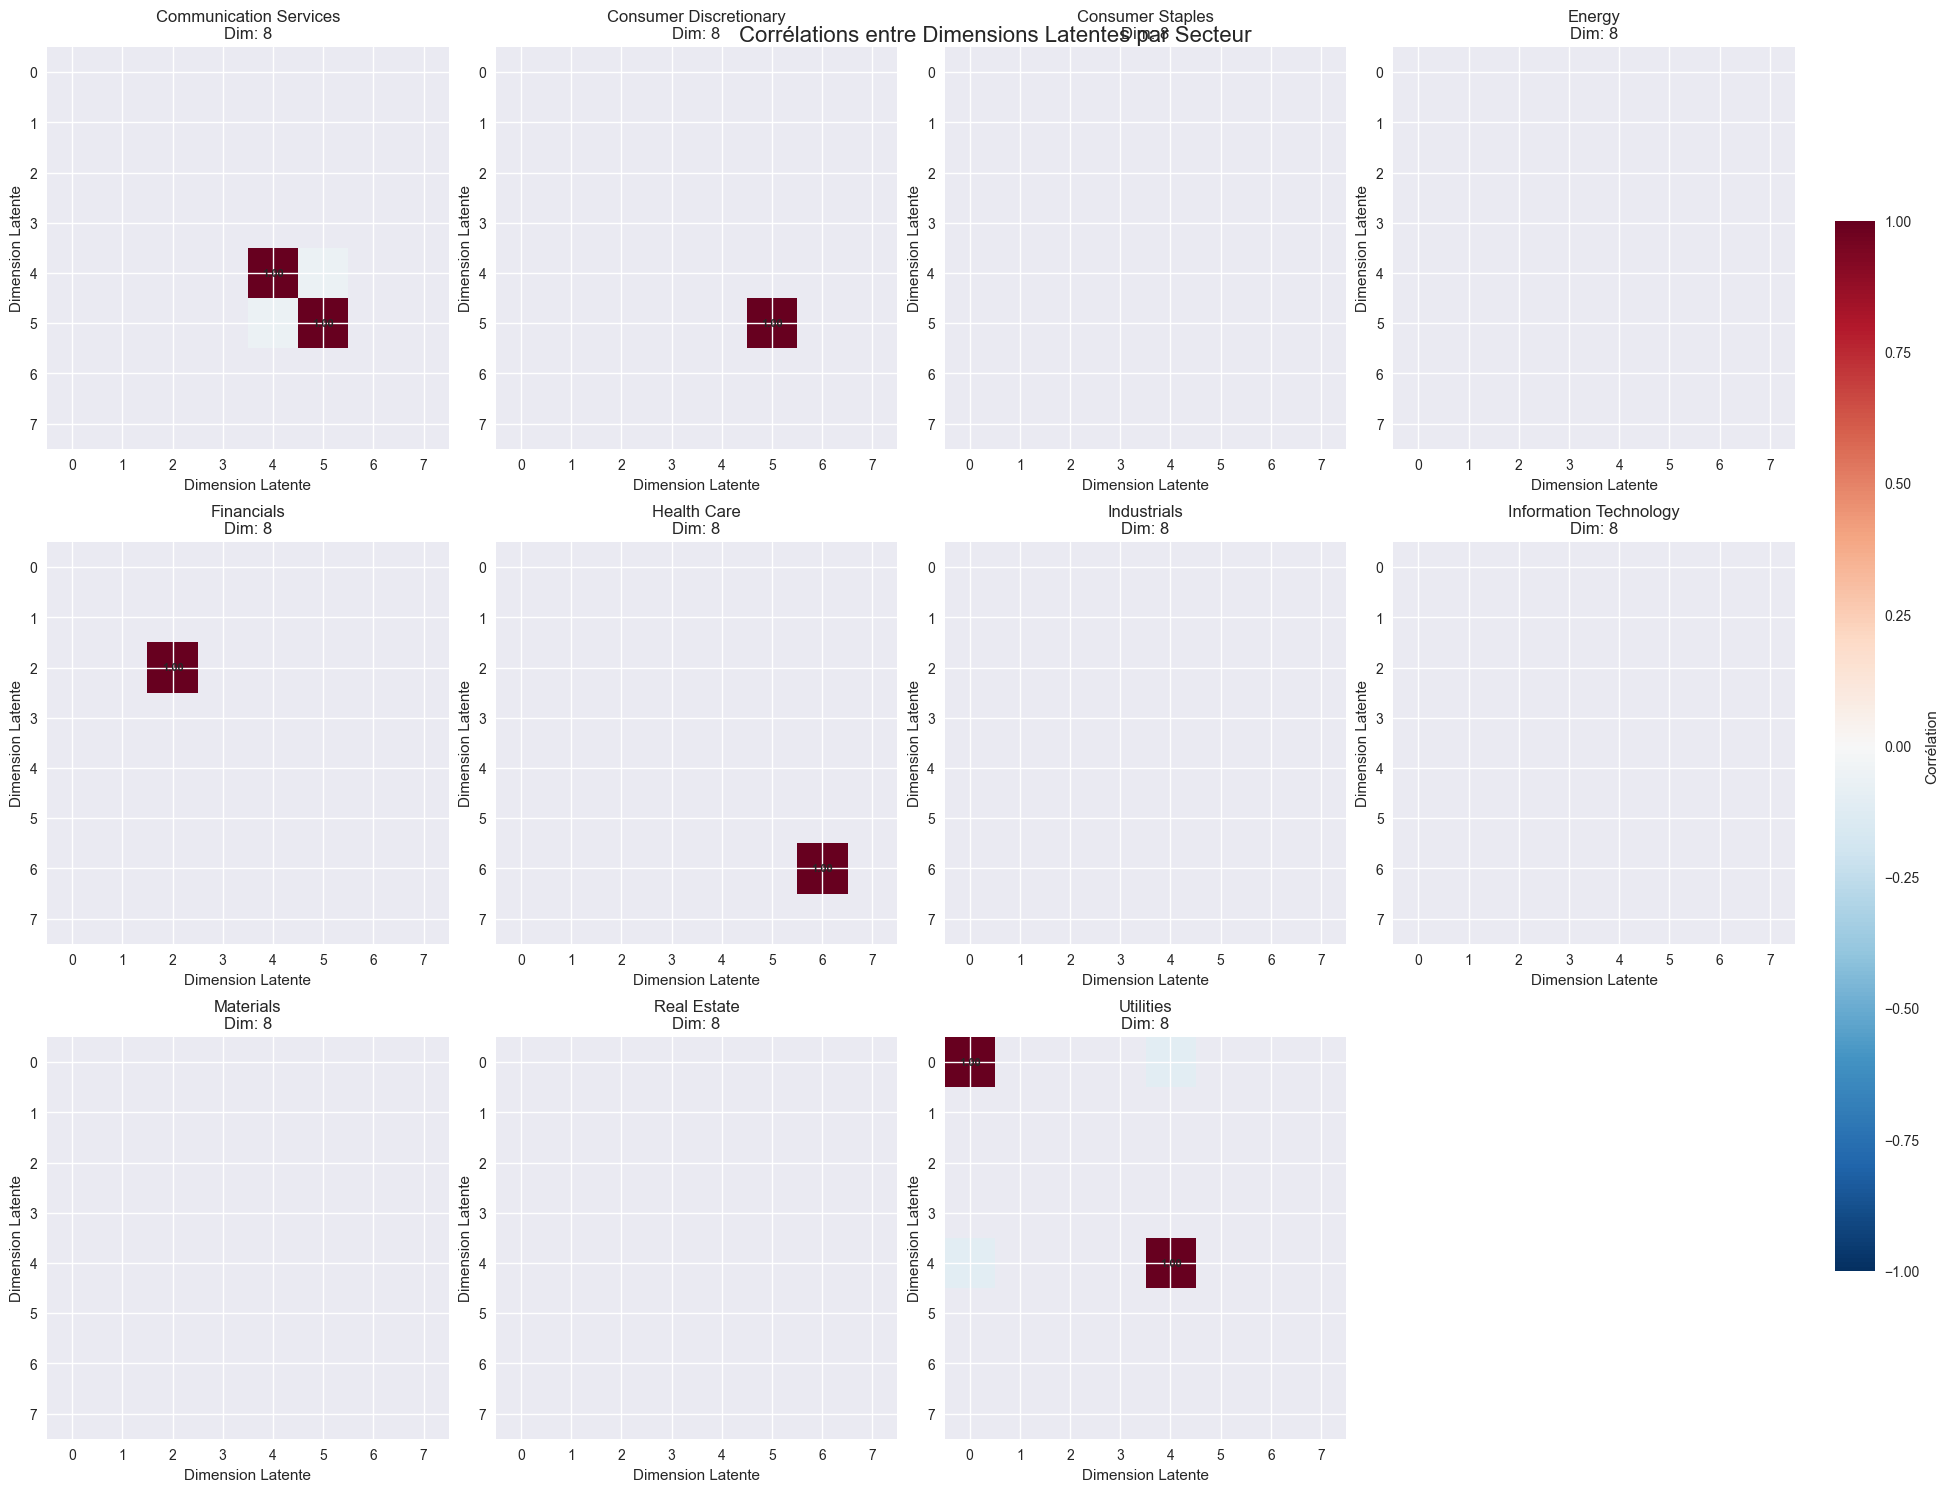

In [10]:
# Analyse des espaces latents
if all_results:
    print("🔍 ANALYSE DES REPRÉSENTATIONS LATENTES")
    print("=" * 60)
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, (sector, results) in enumerate(all_results.items()):
        if i < len(axes):
            latent = results['latent_representation']
            
            # Matrice de corrélation des dimensions latentes
            corr_matrix = np.corrcoef(latent.T)
            
            im = axes[i].imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
            axes[i].set_title(f"{sector.replace('_', ' ').title()}\n"
                             f"Dim: {latent.shape[1]}")
            axes[i].set_xlabel('Dimension Latente')
            axes[i].set_ylabel('Dimension Latente')
            
            # Ajouter les valeurs de corrélation importantes
            for x in range(corr_matrix.shape[0]):
                for y in range(corr_matrix.shape[1]):
                    if abs(corr_matrix[x, y]) > 0.3:  # Afficher seulement les corrélations importantes
                        axes[i].text(y, x, f'{corr_matrix[x, y]:.2f}',
                                   ha='center', va='center', 
                                   fontsize=8, fontweight='bold')
    
    # Masquer les axes non utilisés
    for j in range(len(all_results), len(axes)):
        axes[j].set_visible(False)
    
    # Colorbar commune
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Corrélation')
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    plt.suptitle('Corrélations entre Dimensions Latentes par Secteur', fontsize=16, y=0.98)
    plt.savefig(FIGURES_PATH / 'latent_correlations_par_secteur.png', 
                dpi=300, bbox_inches='tight')
    plt.show()


## 7. Sauvegarde des Résultats


In [12]:
# Sauvegarder les modèles et résultats
if all_results:
    print("💾 SAUVEGARDE DES RÉSULTATS")
    print("=" * 40)
    
    # Créer un dossier pour cette session
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    session_dir = RESULTS_PATH / f'kan_autoencoders_{timestamp}'
    session_dir.mkdir(exist_ok=True)
    
    # Sauvegarder les modèles et métriques
    saved_files = []
    
    for sector, results in all_results.items():
        # Sauvegarder le modèle
        model_path = session_dir / f'kan_autoencoder_{sector}.pth'
        torch.save({
            'model_state_dict': results['model'].state_dict(),
            'config': results['config'],
            'scaler': results['scaler'],
            'test_metrics': results['test_metrics'],
            'training_time': results['training_time']
        }, model_path)
        saved_files.append(model_path)
        
        # Sauvegarder l'historique d'entraînement
        history_path = session_dir / f'training_history_{sector}.json'
        with open(history_path, 'w') as f:
            # Convertir les tensors en listes pour la sérialisation JSON
            history_json = {k: v for k, v in results['history'].items() 
                           if not isinstance(v, torch.Tensor)}
            json.dump(history_json, f, indent=2)
        saved_files.append(history_path)
    
    # Sauvegarder le résumé global
    summary_path = session_dir / 'session_summary.json'
    session_summary = {
        'timestamp': timestamp,
        'total_training_time': total_time,
        'models_trained': len(all_results),
        'kan_config': KAN_CONFIG,
        'training_config': TRAINING_CONFIG,
        'sectors': list(all_results.keys())
    }
    
    with open(summary_path, 'w') as f:
        json.dump(session_summary, f, indent=2)
    saved_files.append(summary_path)
    
    print(f"✅ Session sauvegardée dans: {session_dir}")
    print(f"📁 Fichiers créés: {len(saved_files)}")
    print(f"   • Modèles: {len(all_results)}")
    print(f"   • Historiques: {len(all_results)}")
    print(f"   • Résumé: 1")
    
else:
    print("❌ Aucun résultat à sauvegarder")


💾 SAUVEGARDE DES RÉSULTATS
✅ Session sauvegardée dans: results\kan_autoencoders_20250824_201651
📁 Fichiers créés: 23
   • Modèles: 11
   • Historiques: 11
   • Résumé: 1
